##### code reference: https://colab.research.google.com/drive/1cTdIDT_fsBWGbaljhPSmBI6gwkw-tQ2H#scrollTo=xuAE4cqJ0itR

In [1]:
import os
import csv
import math
import random
import imageio
import argparse
import numpy as np
import PIL.Image as Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
from torchvision import models, datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image, make_grid

from sklearn.manifold import TSNE

In [2]:
def set_same_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_same_seed(0)

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
def csv2list(csv_path):
    gt = []
    with open(csv_path, newline='') as file:
        rows = csv.reader(file)
        for row in rows:
            gt.append(row)
    gt.pop(0)
    return gt

In [5]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, label_csv):
        self.image_dir = image_dir
        self.label_csv = label_csv
        self.data_list = csv2list(label_csv)
        self.data_len = len(self.data_list)
        self.transform = transforms.Compose([transforms.ToTensor(),
                                             transforms.Resize((32,32))])
        self.shape = (3,32,32)
        
    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.data_list[idx][0])
        image = Image.open(img_path)
        image = self.transform(image)
        if image.shape[0] == 1:   # transform 1_channel(gray) to 3_channels
            image = image.repeat(3,1,1)
        label = torch.tensor(int(self.data_list[idx][1]))    
        return image, label

In [6]:
mnistm_image_dir = 'hw2_data/digits/mnistm/data/'
mnistm_train_csv = 'hw2_data/digits/mnistm/train.csv'
mnistm_val_csv = 'hw2_data/digits/mnistm/val.csv'

svhn_image_dir = 'hw2_data/digits/svhn/data/'
svhn_train_csv = 'hw2_data/digits/svhn/train.csv'
svhn_val_csv = 'hw2_data/digits/svhn/val.csv'

usps_image_dir = 'hw2_data/digits/usps/data/'
usps_train_csv = 'hw2_data/digits/usps/train.csv'
usps_val_csv = 'hw2_data/digits/usps/val.csv'

batch_size = 256

In [7]:
mnistm_train_dataset = ImageDataset(mnistm_image_dir, mnistm_train_csv)
mnistm_train_dataloader = DataLoader(mnistm_train_dataset, batch_size=batch_size, shuffle=True)
mnistm_val_dataset = ImageDataset(mnistm_image_dir, mnistm_val_csv)
mnistm_val_dataloader = DataLoader(mnistm_val_dataset, batch_size=batch_size, shuffle=True)

svhn_train_dataset = ImageDataset(svhn_image_dir, svhn_train_csv)
svhn_train_dataloader = DataLoader(svhn_train_dataset, batch_size=batch_size, shuffle=True)
svhn_val_dataset = ImageDataset(svhn_image_dir, svhn_val_csv)
svhn_val_dataloader = DataLoader(svhn_val_dataset, batch_size=batch_size, shuffle=True)

usps_train_dataset = ImageDataset(usps_image_dir, usps_train_csv)
usps_train_dataloader = DataLoader(usps_train_dataset, batch_size=batch_size, shuffle=True)
usps_val_dataset = ImageDataset(usps_image_dir, usps_val_csv)
usps_val_dataloader = DataLoader(usps_val_dataset, batch_size=batch_size, shuffle=True)

Feature batch shape: torch.Size([256, 3, 32, 32])
Labels batch shape: torch.Size([256])


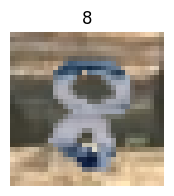

torch.Size([3, 32, 32])


In [8]:
images, labels  = next(iter(mnistm_train_dataloader))
print(f"Feature batch shape: {images.size()}")
print(f"Labels batch shape: {labels.size()}")
idx = 0
plt.figure(figsize=(2,2))
plt.imshow(images[idx].moveaxis(0, 2))
plt.title(labels[idx].item())
plt.axis('off')
plt.show()
print(images[idx].shape)

Feature batch shape: torch.Size([256, 3, 32, 32])
Labels batch shape: torch.Size([256])


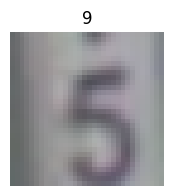

torch.Size([3, 32, 32])


In [9]:
images, labels  = next(iter(svhn_train_dataloader))
print(f"Feature batch shape: {images.size()}")
print(f"Labels batch shape: {labels.size()}")
idx = 0
plt.figure(figsize=(2,2))
plt.imshow(images[idx].moveaxis(0, 2), cmap='gray')
plt.title(labels[idx].item())
plt.axis('off')
plt.show()
print(images[idx].shape)

Feature batch shape: torch.Size([256, 3, 32, 32])
Labels batch shape: torch.Size([256])


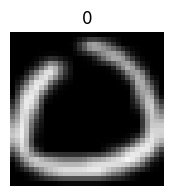

torch.Size([3, 32, 32])


In [10]:
images, labels  = next(iter(usps_train_dataloader))
print(f"Feature batch shape: {images.size()}")
print(f"Labels batch shape: {labels.size()}")
idx = 0
plt.figure(figsize=(2,2))
plt.imshow(images[idx].moveaxis(0, 2))
plt.title(labels[idx].item())
plt.axis('off')
plt.show()
print(images[idx].shape)

In [11]:
class FeatureExtractor(nn.Module):

    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
    def forward(self, x):
        x = self.conv(x).squeeze()
        return x

In [12]:
class LabelPredictor(nn.Module):

    def __init__(self):
        super(LabelPredictor, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c

In [13]:
class DomainClassifier(nn.Module):

    def __init__(self):
        super(DomainClassifier, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1),
        )

    def forward(self, h):
        y = self.layer(h)
        return y

In [14]:
feature_extractor = FeatureExtractor()
print(feature_extractor)

FeatureExtractor(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [15]:
label_predictor = LabelPredictor()
print(label_predictor)

LabelPredictor(
  (layer): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [16]:
domain_classifier = DomainClassifier()
print(domain_classifier)

DomainClassifier(
  (layer): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=512, bias=True)
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [14]:
def evaluate(test_dataloader, feature_extractor, label_predictor):

    feature_extractor.eval()
    label_predictor.eval()
    set_same_seed(0)
    
    with torch.no_grad():
        hit, total = 0, 0
        for x, y in test_dataloader:
            x = x.to(device)
            y = y.to(device)
            p = feature_extractor(x)
            p = label_predictor(p)
            total += len(y)
            hit += (p.argmax(1)==y).sum().item()
        return hit/total

In [15]:
def get_features(dataloader, feature_extractor):
    features = np.zeros((1,512))
    labels = np.array([])
    feature_extractor.eval()
    set_same_seed(0)
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            fs = feature_extractor(x)
            for i, f in enumerate(fs):
                a = f.unsqueeze(0).detach().to('cpu').numpy()
                b = y[i].numpy()
                features = np.append(features, a, axis=0)
                labels = np.append(labels, b)
    features = features[1:]
    return features, labels

In [16]:
def dann_train(source_dataloader, target_dataloader, lamb):

    running_D_loss, running_F_loss = 0.0, 0.0
    total_hit, total_num = 0.0, 0.0

    for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):

        optimizer_D.zero_grad()
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()
        
        source_data = source_data.to(device)
        source_label = source_label.to(device)
        target_data = target_data.to(device)
        
        mixed_data = torch.cat([source_data, target_data], dim=0)
        domain_label = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).to(device)
        domain_label[:source_data.shape[0]] = 1

        feature = feature_extractor(mixed_data)
        domain_logits = domain_classifier(feature.detach())
        loss = domain_criterion(domain_logits, domain_label)
        running_D_loss += loss.item()
        loss.backward()
        optimizer_D.step()

        class_logits = label_predictor(feature[:source_data.shape[0]])
        domain_logits = domain_classifier(feature)
        loss = class_criterion(class_logits, source_label) - lamb * domain_criterion(domain_logits, domain_label)
        running_F_loss+= loss.item()
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()

        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        total_num += source_data.shape[0]
        print(i, end='\r')

    return running_D_loss/(i+1), running_F_loss/(i+1), total_hit/total_num

In [17]:
## dann mnistm 2 svhn

In [18]:
feature_extractor = FeatureExtractor()
label_predictor = LabelPredictor()
domain_classifier = DomainClassifier()

feature_extractor = torch.load('DANN/feature_extractor_mnistm2svhn.pth')
label_predictor = torch.load('DANN/label_predictor_mnistm2svhn.pth')
domain_classifier = torch.load('DANN/domain_classifier_mnistm2svhn.pth')

feature_extractor = feature_extractor.to(device)
label_predictor = label_predictor.to(device)
domain_classifier = domain_classifier.to(device)

class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

optimizer_F = optim.Adam(feature_extractor.parameters())
optimizer_C = optim.Adam(label_predictor.parameters())
optimizer_D = optim.Adam(domain_classifier.parameters())

In [64]:
source_dataloader = mnistm_train_dataloader
target_dataloader = svhn_train_dataloader

feature_extractor.train()
label_predictor.train()
domain_classifier.train()

for epoch in range(200):
    train_D_loss, train_F_loss, train_acc = dann_train(source_dataloader, target_dataloader, lamb=0.3)
    print('epoch {:>3d}: train D loss: {:6.4f}, train F loss: {:6.4f}, acc {:6.4f}'.format(epoch, train_D_loss, train_F_loss, train_acc))

epoch   0: train D loss: 0.7242, train F loss: 0.8297, acc 0.6316
epoch   1: train D loss: 0.8001, train F loss: -0.0009, acc 0.9302
epoch   2: train D loss: 0.7034, train F loss: -0.0263, acc 0.9455
epoch   3: train D loss: 0.7598, train F loss: -0.0749, acc 0.9557
epoch   4: train D loss: 0.7245, train F loss: -0.1155, acc 0.9693
epoch   5: train D loss: 0.6666, train F loss: -0.1042, acc 0.9720
epoch   6: train D loss: 0.6348, train F loss: -0.1109, acc 0.9756
epoch   7: train D loss: 0.6572, train F loss: -0.1196, acc 0.9767
epoch   8: train D loss: 0.6421, train F loss: -0.1318, acc 0.9817
epoch   9: train D loss: 0.6601, train F loss: -0.1544, acc 0.9859
epoch  10: train D loss: 0.7033, train F loss: -0.1663, acc 0.9862
epoch  11: train D loss: 0.6748, train F loss: -0.1631, acc 0.9887
epoch  12: train D loss: 0.6699, train F loss: -0.1677, acc 0.9901
epoch  13: train D loss: 0.7054, train F loss: -0.1747, acc 0.9896
epoch  14: train D loss: 0.7005, train F loss: -0.1700, acc 0.9

epoch 123: train D loss: 0.6455, train F loss: -0.1855, acc 0.9981
epoch 124: train D loss: 0.6529, train F loss: -0.1867, acc 0.9979
epoch 125: train D loss: 0.6469, train F loss: -0.1852, acc 0.9981
epoch 126: train D loss: 0.6512, train F loss: -0.1882, acc 0.9983
epoch 127: train D loss: 0.6495, train F loss: -0.1870, acc 0.9984
epoch 128: train D loss: 0.6497, train F loss: -0.1869, acc 0.9984
epoch 129: train D loss: 0.6527, train F loss: -0.1858, acc 0.9979
epoch 130: train D loss: 0.6488, train F loss: -0.1865, acc 0.9982
epoch 131: train D loss: 0.6496, train F loss: -0.1873, acc 0.9983
epoch 132: train D loss: 0.6584, train F loss: -0.1897, acc 0.9982
epoch 133: train D loss: 0.6612, train F loss: -0.1915, acc 0.9983
epoch 134: train D loss: 0.6542, train F loss: -0.1880, acc 0.9979
epoch 135: train D loss: 0.6546, train F loss: -0.1895, acc 0.9985
epoch 136: train D loss: 0.6463, train F loss: -0.1839, acc 0.9977
epoch 137: train D loss: 0.6497, train F loss: -0.1878, acc 0.

In [67]:
acc = evaluate(svhn_val_dataloader, feature_extractor, label_predictor)
print(acc)

0.561654182665072


In [51]:
torch.save(feature_extractor, 'feature_extractor_mnistm2svhn.pth')
torch.save(label_predictor, 'label_predictor_mnistm2svhn.pth')
torch.save(domain_classifier, 'domain_classifier_mnistm2svhn.pth')

In [42]:
## dann mnistm 2 usps

In [19]:
feature_extractor = FeatureExtractor()
label_predictor = LabelPredictor()
domain_classifier = DomainClassifier()

feature_extractor = torch.load('DANN/feature_extractor_mnistm2usps.pth')
label_predictor = torch.load('DANN/label_predictor_mnistm2usps.pth')
domain_classifier = torch.load('DANN/domain_classifier_mnistm2usps.pth')

feature_extractor = feature_extractor.to(device)
label_predictor = label_predictor.to(device)
domain_classifier = domain_classifier.to(device)

class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

optimizer_F = optim.Adam(feature_extractor.parameters())
optimizer_C = optim.Adam(label_predictor.parameters())
optimizer_D = optim.Adam(domain_classifier.parameters())

In [57]:
source_dataloader = mnistm_train_dataloader
target_dataloader = usps_train_dataloader

feature_extractor.train()
label_predictor.train()
domain_classifier.train()

for epoch in range(200):
    train_D_loss, train_F_loss, train_acc = dann_train(source_dataloader, target_dataloader, lamb=0.3)
    print('epoch {:>3d}: train D loss: {:6.4f}, train F loss: {:6.4f}, acc {:6.4f}'.format(epoch, train_D_loss, train_F_loss, train_acc))

epoch   0: train D loss: 0.9628, train F loss: 1.7859, acc 0.3361
epoch   1: train D loss: 0.6453, train F loss: 0.6282, acc 0.7739
epoch   2: train D loss: 0.6414, train F loss: 0.2785, acc 0.8882
epoch   3: train D loss: 0.8914, train F loss: 0.1934, acc 0.9113
epoch   4: train D loss: 0.6527, train F loss: 0.1729, acc 0.9238
epoch   5: train D loss: 0.8816, train F loss: 0.1386, acc 0.9323
epoch   6: train D loss: 0.6410, train F loss: 0.1139, acc 0.9422
epoch   7: train D loss: 0.7016, train F loss: 0.0952, acc 0.9484
epoch   8: train D loss: 0.7606, train F loss: 0.0943, acc 0.9486
epoch   9: train D loss: 0.7667, train F loss: 0.0885, acc 0.9525
epoch  10: train D loss: 0.7021, train F loss: 0.0710, acc 0.9513
epoch  11: train D loss: 0.7257, train F loss: 0.0499, acc 0.9603
epoch  12: train D loss: 0.6736, train F loss: 0.0339, acc 0.9692
epoch  13: train D loss: 0.7153, train F loss: 0.0281, acc 0.9692
epoch  14: train D loss: 0.6762, train F loss: 0.0228, acc 0.9694
epoch  15:

epoch 123: train D loss: 0.7140, train F loss: -0.0584, acc 0.9963
epoch 124: train D loss: 0.6790, train F loss: -0.0519, acc 0.9946
epoch 125: train D loss: 0.7040, train F loss: -0.0521, acc 0.9932
epoch 126: train D loss: 0.6924, train F loss: -0.0479, acc 0.9920
epoch 127: train D loss: 0.6847, train F loss: -0.0462, acc 0.9932
epoch 128: train D loss: 0.6755, train F loss: -0.0502, acc 0.9948
epoch 129: train D loss: 0.6702, train F loss: -0.0553, acc 0.9958
epoch 130: train D loss: 0.6653, train F loss: -0.0592, acc 0.9979
epoch 131: train D loss: 0.6422, train F loss: -0.0507, acc 0.9956
epoch 132: train D loss: 0.7277, train F loss: -0.0601, acc 0.9967
epoch 133: train D loss: 0.6550, train F loss: -0.0511, acc 0.9953
epoch 134: train D loss: 0.7406, train F loss: -0.0595, acc 0.9950
epoch 135: train D loss: 0.6687, train F loss: -0.0474, acc 0.9938
epoch 136: train D loss: 0.7179, train F loss: -0.0567, acc 0.9959
epoch 137: train D loss: 0.6699, train F loss: -0.0552, acc 0.

In [17]:
acc = evaluate(usps_val_dataloader, feature_extractor, label_predictor)
print(acc)

0.9388440860215054


In [54]:
torch.save(feature_extractor, 'feature_extractor_mnistm2usps.pth')
torch.save(label_predictor, 'label_predictor_mnistm2usps.pth')
torch.save(domain_classifier, 'domain_classifier_mnistm2usps.pth')

In [16]:
feature_extractor = FeatureExtractor()
feature_extractor = torch.load('DANN/feature_extractor_mnistm2svhn.pth')
feature_extractor = feature_extractor.to(device)

In [17]:
svhn_features, svhn_labels = get_features(svhn_val_dataloader, feature_extractor)
print(svhn_features.shape, svhn_labels.shape)

(15887, 512) (15887,)


In [18]:
mnistm_features1, mnistm_labels1 = get_features(mnistm_val_dataloader, feature_extractor)
print(mnistm_features1.shape, mnistm_labels1.shape)

(11200, 512) (11200,)


In [19]:
mix_features1 = np.append(svhn_features, mnistm_features1, axis=0)
mix_features1.shape

(27087, 512)

In [81]:
tsne_mix1 = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50).fit_transform(mix_features1)
tsne_mix1.shape

(27087, 2)

In [82]:
tsne_svhn = tsne_mix1[:15887]
tsne_mnistm1 = tsne_mix1[15887:]
print(tsne_svhn.shape, tsne_mnistm1.shape)

(15887, 2) (11200, 2)


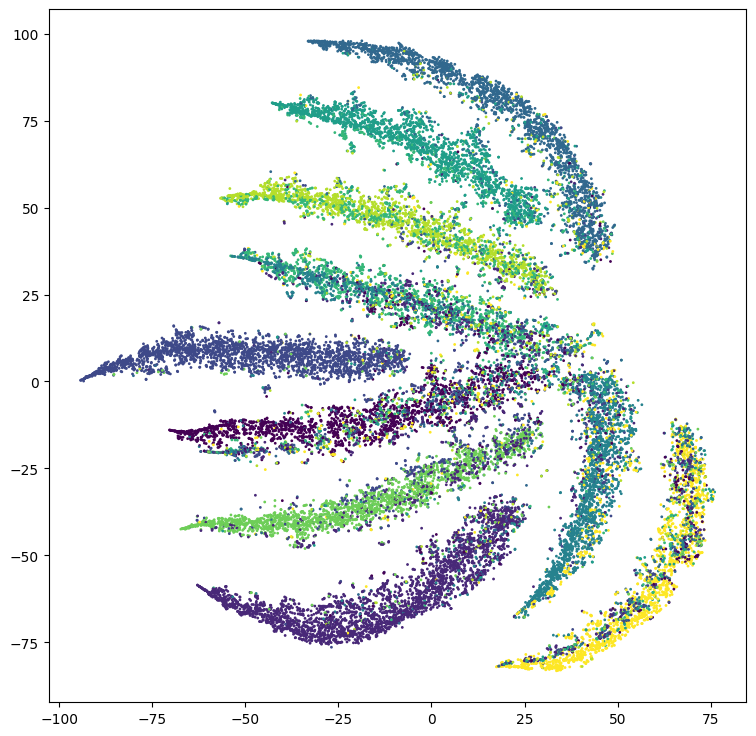

In [103]:
plt.figure(figsize=(9,9))
plt.scatter(tsne_mnistm1[:,0], tsne_mnistm1[:,1], s=1, c=mnistm_labels1)
plt.scatter(tsne_svhn[:,0], tsne_svhn[:,1], s=1, c=svhn_labels)
plt.show()

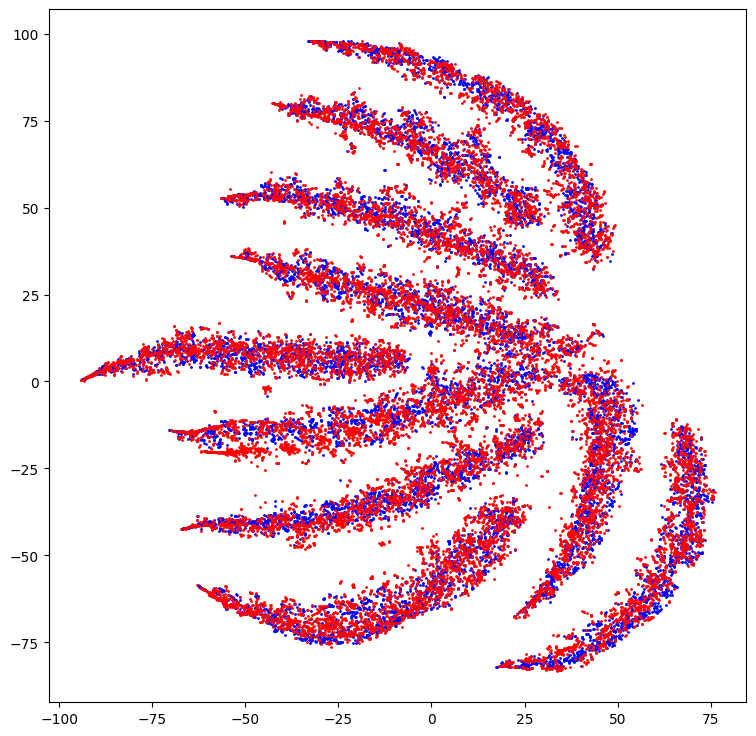

In [102]:
plt.figure(figsize=(9,9))
plt.scatter(tsne_mnistm1[:,0], tsne_mnistm1[:,1], s=1, c='b')
plt.scatter(tsne_svhn[:,0], tsne_svhn[:,1], s=1, c='r')
plt.show()

In [43]:
feature_extractor = FeatureExtractor()
feature_extractor = torch.load('DANN/feature_extractor_mnistm2usps.pth')
feature_extractor = feature_extractor.to(device)

In [44]:
usps_features, usps_labels = get_features(usps_val_dataloader, feature_extractor)
print(usps_features.shape, usps_labels.shape)

(1488, 512) (1488,)


In [45]:
mnistm_features2, mnistm_labels2 = get_features(mnistm_val_dataloader, feature_extractor)
print(mnistm_features2.shape, mnistm_labels2.shape)

(11200, 512) (11200,)


In [46]:
mix_features2 = np.append(usps_features, mnistm_features2, axis=0)
mix_features2.shape

(12688, 512)

In [93]:
tsne_mix2 = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50).fit_transform(mix_features2)
tsne_mix2.shape

(12688, 2)

In [94]:
tsne_usps = tsne_mix2[:1488]
tsne_mnistm2 = tsne_mix2[1488:]
print(tsne_usps.shape, tsne_mnistm2.shape)

(1488, 2) (11200, 2)


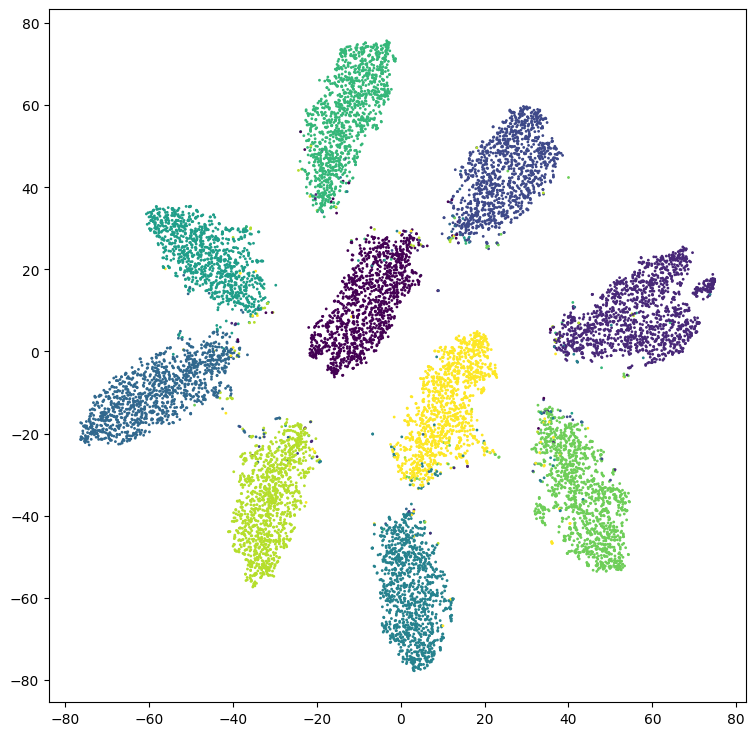

In [106]:
plt.figure(figsize=(9,9))
plt.scatter(tsne_mnistm2[:,0], tsne_mnistm2[:,1], s=1, c=mnistm_labels2)
plt.scatter(tsne_usps[:,0], tsne_usps[:,1], s=1, c=usps_labels)
plt.show()

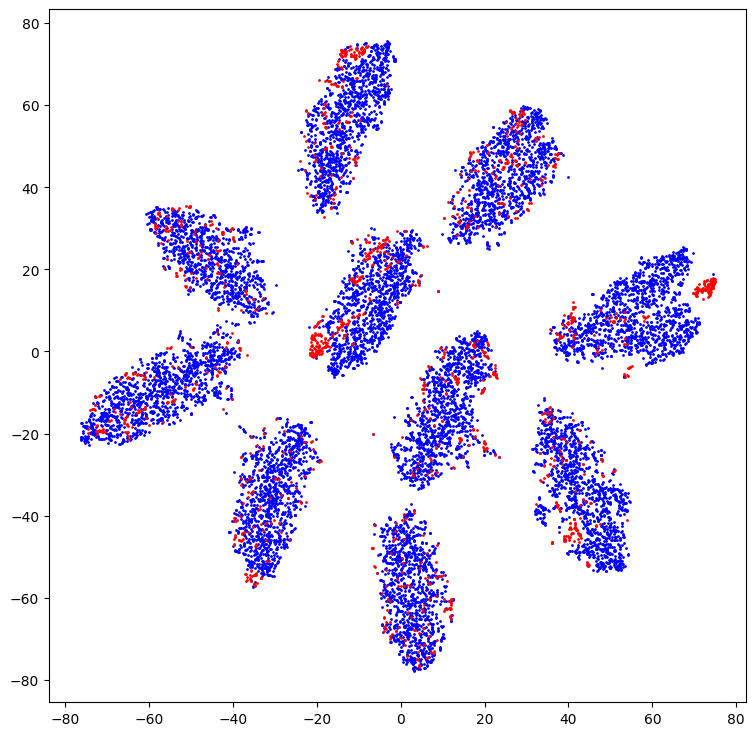

In [107]:
plt.figure(figsize=(9,9))
plt.scatter(tsne_mnistm2[:,0], tsne_mnistm2[:,1], s=1, c='b')
plt.scatter(tsne_usps[:,0], tsne_usps[:,1], s=1, c='r')
plt.show()

In [16]:
def cnn_train(dataloader):
    
    optimizer_F.zero_grad()
    optimizer_C.zero_grad()
    
    running_F_loss = 0.0
    total_hit, total_num = 0.0, 0.0

    for i, (data, label) in enumerate(dataloader):

        data = data.to(device)
        label = label.to(device)

        feature = feature_extractor(data)
        class_logits = label_predictor(feature)

        loss = class_criterion(class_logits, label)
        running_F_loss+= loss.item()
        loss.backward()
        
        optimizer_F.step()
        optimizer_C.step()

        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == label).item()
        total_num += data.shape[0]
        print(i, end='\r')

    return running_F_loss / (i+1), total_hit / total_num

In [17]:
# cnn mnistm

In [70]:
feature_extractor = FeatureExtractor()
label_predictor = LabelPredictor()

feature_extractor = torch.load('DANN/feature_extractor_mnistm.pth')
label_predictor = torch.load('DANN/label_predictor_mnistm.pth')

label_predictor = label_predictor.to(device)
feature_extractor = feature_extractor.to(device)

class_criterion = nn.CrossEntropyLoss()

optimizer_F = optim.Adam(feature_extractor.parameters(), lr=1e-4)
optimizer_C = optim.Adam(label_predictor.parameters(), lr=1e-4)

In [19]:
dataloader = mnistm_train_dataloader

feature_extractor.train()
label_predictor.train()

for epoch in range(200):
    train_F_loss, train_acc = cnn_train(dataloader)
    print('epoch {:>3d}: train F loss: {:6.4f}, acc {:6.4f}'.format(epoch, train_F_loss, train_acc))

epoch   0: train F loss: 1.9175, acc 0.3246
epoch   1: train F loss: 1.6120, acc 0.4652
epoch   2: train F loss: 1.1236, acc 0.6204
epoch   3: train F loss: 1.2134, acc 0.5967
epoch   4: train F loss: 0.8616, acc 0.7197
epoch   5: train F loss: 0.7486, acc 0.7586
epoch   6: train F loss: 0.6088, acc 0.8191
epoch   7: train F loss: 0.6282, acc 0.8044
epoch   8: train F loss: 0.4881, acc 0.8455
epoch   9: train F loss: 0.3744, acc 0.8850
epoch  10: train F loss: 0.3477, acc 0.8916
epoch  11: train F loss: 0.2630, acc 0.9216
epoch  12: train F loss: 0.2356, acc 0.9271
epoch  13: train F loss: 0.2192, acc 0.9343
epoch  14: train F loss: 0.2442, acc 0.9251
epoch  15: train F loss: 0.2111, acc 0.9354
epoch  16: train F loss: 0.1856, acc 0.9434
epoch  17: train F loss: 0.1917, acc 0.9423
epoch  18: train F loss: 0.1971, acc 0.9396
epoch  19: train F loss: 0.1397, acc 0.9584
epoch  20: train F loss: 0.1459, acc 0.9557
epoch  21: train F loss: 0.1961, acc 0.9413
epoch  22: train F loss: 0.1955,

epoch 187: train F loss: 0.0000, acc 1.0000
epoch 188: train F loss: 0.0000, acc 1.0000
epoch 189: train F loss: 0.0000, acc 1.0000
epoch 190: train F loss: 0.0000, acc 1.0000
epoch 191: train F loss: 0.0000, acc 1.0000
epoch 192: train F loss: 0.0000, acc 1.0000
epoch 193: train F loss: 0.0000, acc 1.0000
epoch 194: train F loss: 0.0000, acc 1.0000
epoch 195: train F loss: 0.0000, acc 1.0000
epoch 196: train F loss: 0.0000, acc 1.0000
epoch 197: train F loss: 0.0000, acc 1.0000
epoch 198: train F loss: 0.0000, acc 1.0000
epoch 199: train F loss: 0.0000, acc 1.0000


In [71]:
acc = evaluate(svhn_val_dataloader, feature_extractor, label_predictor)
print(acc)

0.2880971863788003


In [72]:
acc = evaluate(usps_val_dataloader, feature_extractor, label_predictor)
print(acc)

0.7735215053763441


In [22]:
torch.save(feature_extractor, 'feature_extractor_mnistm.pth')
torch.save(label_predictor, 'label_predictor_mnistm.pth')

In [23]:
# cnn svhn

In [73]:
feature_extractor = FeatureExtractor()
label_predictor = LabelPredictor()

feature_extractor = torch.load('DANN/feature_extractor_svhn.pth')
label_predictor = torch.load('DANN/label_predictor_svhn.pth')

label_predictor = label_predictor.to(device)
feature_extractor = feature_extractor.to(device)

class_criterion = nn.CrossEntropyLoss()

optimizer_F = optim.Adam(feature_extractor.parameters(), lr=1e-4)
optimizer_C = optim.Adam(label_predictor.parameters(), lr=1e-4)

In [25]:
dataloader = svhn_train_dataloader

feature_extractor.train()
label_predictor.train()

for epoch in range(200):
    train_F_loss, train_acc = cnn_train(dataloader)
    print('epoch {:>3d}: train F loss: {:6.4f}, acc {:6.4f}'.format(epoch, train_F_loss, train_acc))

epoch   0: train F loss: 2.1330, acc 0.2318
epoch   1: train F loss: 2.0107, acc 0.2733
epoch   2: train F loss: 1.8693, acc 0.3324
epoch   3: train F loss: 1.6436, acc 0.3920
epoch   4: train F loss: 1.5030, acc 0.4545
epoch   5: train F loss: 1.4135, acc 0.4902
epoch   6: train F loss: 1.2313, acc 0.5500
epoch   7: train F loss: 1.1204, acc 0.6070
epoch   8: train F loss: 1.0529, acc 0.6336
epoch   9: train F loss: 1.0370, acc 0.6460
epoch  10: train F loss: 0.9703, acc 0.6734
epoch  11: train F loss: 0.8158, acc 0.7359
epoch  12: train F loss: 0.8288, acc 0.7298
epoch  13: train F loss: 0.6849, acc 0.7843
epoch  14: train F loss: 0.7490, acc 0.7659
epoch  15: train F loss: 0.7435, acc 0.7570
epoch  16: train F loss: 0.5672, acc 0.8281
epoch  17: train F loss: 0.5233, acc 0.8376
epoch  18: train F loss: 0.4383, acc 0.8674
epoch  19: train F loss: 0.4019, acc 0.8789
epoch  20: train F loss: 0.4002, acc 0.8777
epoch  21: train F loss: 0.3937, acc 0.8802
epoch  22: train F loss: 0.3990,

epoch 187: train F loss: 0.0036, acc 0.9992
epoch 188: train F loss: 0.0049, acc 0.9986
epoch 189: train F loss: 0.0059, acc 0.9983
epoch 190: train F loss: 0.0116, acc 0.9966
epoch 191: train F loss: 0.0105, acc 0.9971
epoch 192: train F loss: 0.0075, acc 0.9979
epoch 193: train F loss: 0.0077, acc 0.9978
epoch 194: train F loss: 0.0153, acc 0.9955
epoch 195: train F loss: 0.0107, acc 0.9968
epoch 196: train F loss: 0.0064, acc 0.9981
epoch 197: train F loss: 0.0080, acc 0.9979
epoch 198: train F loss: 0.0071, acc 0.9983
epoch 199: train F loss: 0.0071, acc 0.9983


In [75]:
acc = evaluate(svhn_val_dataloader, feature_extractor, label_predictor)
print(acc)

0.9214452067728331


In [27]:
torch.save(feature_extractor, 'feature_extractor_svhn.pth')
torch.save(label_predictor, 'label_predictor_svhn.pth')

In [28]:
# cnn usps

In [85]:
feature_extractor = FeatureExtractor()
label_predictor = LabelPredictor()

feature_extractor = torch.load('DANN/feature_extractor_usps.pth')
label_predictor = torch.load('DANN/label_predictor_usps.pth')

label_predictor = label_predictor.to(device)
feature_extractor = feature_extractor.to(device)

class_criterion = nn.CrossEntropyLoss()

optimizer_F = optim.Adam(feature_extractor.parameters(), lr=1e-4)
optimizer_C = optim.Adam(label_predictor.parameters(), lr=1e-4)

In [32]:
dataloader = usps_train_dataloader

feature_extractor.train()
label_predictor.train()

for epoch in range(200):
    train_F_loss, train_acc = cnn_train(dataloader)
    print('epoch {:>3d}: train F loss: {:6.4f}, acc {:6.4f}'.format(epoch, train_F_loss, train_acc))

epoch   0: train F loss: 1.5030, acc 0.5802
epoch   1: train F loss: 0.5741, acc 0.8829
epoch   2: train F loss: 0.3800, acc 0.8921
epoch   3: train F loss: 0.5015, acc 0.8593
epoch   4: train F loss: 0.7274, acc 0.8139
epoch   5: train F loss: 0.4950, acc 0.8691
epoch   6: train F loss: 0.4380, acc 0.8750
epoch   7: train F loss: 0.5754, acc 0.8119
epoch   8: train F loss: 0.4666, acc 0.8677
epoch   9: train F loss: 0.3963, acc 0.8761
epoch  10: train F loss: 0.2711, acc 0.9182
epoch  11: train F loss: 0.1618, acc 0.9494
epoch  12: train F loss: 0.1337, acc 0.9587
epoch  13: train F loss: 0.1189, acc 0.9624
epoch  14: train F loss: 0.0618, acc 0.9830
epoch  15: train F loss: 0.0498, acc 0.9854
epoch  16: train F loss: 0.0386, acc 0.9903
epoch  17: train F loss: 0.0329, acc 0.9914
epoch  18: train F loss: 0.0284, acc 0.9929
epoch  19: train F loss: 0.0251, acc 0.9938
epoch  20: train F loss: 0.0225, acc 0.9953
epoch  21: train F loss: 0.0205, acc 0.9955
epoch  22: train F loss: 0.0178,

epoch 187: train F loss: 0.0000, acc 1.0000
epoch 188: train F loss: 0.0000, acc 1.0000
epoch 189: train F loss: 0.0000, acc 1.0000
epoch 190: train F loss: 0.0000, acc 1.0000
epoch 191: train F loss: 0.0000, acc 1.0000
epoch 192: train F loss: 0.0000, acc 1.0000
epoch 193: train F loss: 0.0000, acc 1.0000
epoch 194: train F loss: 0.0000, acc 1.0000
epoch 195: train F loss: 0.0000, acc 1.0000
epoch 196: train F loss: 0.0000, acc 1.0000
epoch 197: train F loss: 0.0000, acc 1.0000
epoch 198: train F loss: 0.0000, acc 1.0000
epoch 199: train F loss: 0.0000, acc 1.0000


In [86]:
acc = evaluate(usps_val_dataloader, feature_extractor, label_predictor)
print(acc)

0.9879032258064516


In [34]:
torch.save(feature_extractor, 'feature_extractor_usps.pth')
torch.save(label_predictor, 'label_predictor_usps.pth')